In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

from tqdm.auto import tqdm

C:\Users\DELL PC\anaconda3\envs\ml-ZoomCamp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# # Download the data and read it with pandas 
df = pd.read_csv('data.csv')

In [4]:
# Make column names uniform 
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Feature Selection
df = df[['make', 'model', 'year', 'engine_hp',
       'engine_cylinders', 'transmission_type',  'vehicle_style',
       'highway_mpg', 'city_mpg', 'msrp']]

# Make all items uniform
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

# Fill Missing values with zero(0)
df['engine_hp'] = df['engine_hp'].fillna(0)
df['engine_cylinders'] = df['engine_cylinders'].fillna(0)

In [5]:
df1 = df.copy()

In [6]:
# Convert msrp to 1 and 0
df1['above_average'] = (df1.msrp > df1.msrp.mean()).astype(int)
df1 = df1.drop(['msrp'], axis=1)

In [7]:
# Setting Validation Framework
df_full_train, df_test = train_test_split(df1, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_full_train = df_full_train.reset_index(drop=True)

y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']


### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score and compute AUC with the above_average variable
Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

engine_hp\
engine_cylinders\
highway_mpg\
city_mpg

In [8]:
categorical = ['make', 'model', 'transmission_type',  'vehicle_style']
numerical = [ 'year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg' ]


In [9]:
for c in numerical:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    print('%9s: %.3f' % (c, auc))

     year: 0.688
engine_hp: 0.917
engine_cylinders: 0.766
highway_mpg: 0.633
 city_mpg: 0.673


Answer: engine_hp has the highest AUC

### Question 2: Training the model
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
What's the AUC of this model on the validation dataset? (round to 3 digits)

In [10]:
# USe Scikit-Learn to encode categorical features

dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

# Train a model with Scikit-Learn
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [11]:
y_pred = model.predict_proba(X_val)[:, 1]

In [12]:
roc_auc_score(y_val, y_pred)

0.9761329930330412

Answer: 0.976

### Question 3: Precision and Recall
Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01\
For each threshold, compute precision and recall\
Plot them\
At which threshold precision and recall curves intersect?

In [13]:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores

In [14]:
df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,654,1729,0,0
10,0.1,644,358,10,1371
20,0.2,625,226,29,1503
30,0.3,603,156,51,1573
40,0.4,585,112,69,1617
50,0.5,568,72,86,1657
60,0.6,518,52,136,1677
70,0.7,489,29,165,1700
80,0.8,427,14,227,1715
90,0.9,349,4,305,1725


In [15]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

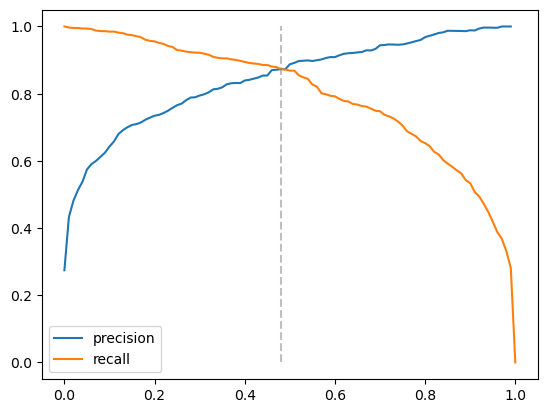

In [16]:
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.vlines(0.48, 0, 1, color='grey', linestyle='--', alpha=0.5)

plt.legend()
plt.show()

Question 4: F1 score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

 

Where 
 P is precision and 
 R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

In [17]:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

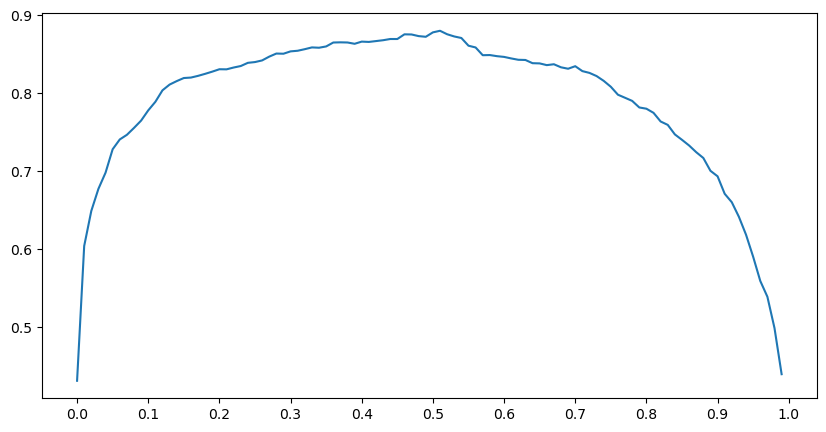

In [18]:
plt.figure(figsize=(10, 5))

plt.plot(df_scores.threshold, df_scores.f1)

plt.xticks(np.linspace(0, 1, 11))
plt.show()

Answer: 0.52

### Question 5: 5-Fold CV
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)\
Iterate over different folds of df_full_train\
Split the data into train and validation\
    Train the model on train with these parameters:  LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)\
Use AUC to evaluate the model on validation\
How large is standard devidation of the scores across different folds?

In [19]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [20]:
scores = []
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.above_average.values
    y_val = df_val.above_average.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.980 +- 0.003


In [21]:
Answer: 0.003

### Question 6: Hyperparemeter Tuning
Now let's use 5-Fold cross-validation to find the best parameter C

Iterate over the following C values: [0.01, 0.1, 0.5, 10]\
Initialize KFold with the same parameters as previously\
Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)\
Compute the mean score as well as the std (round the mean and std to 3 decimal digits)\
Which C leads to the best mean score?

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [22]:
n_splits = 5

for C in tqdm([0.01, 0.1, 0.5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
        
    scores = []
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
            
        y_train = df_train.above_average.values
        y_val = df_val.above_average.values
            
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
            
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
            
        

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

 25%|██▌       | 1/4 [00:01<00:03,  1.25s/it]

C=0.01 0.952 +- 0.002


 50%|█████     | 2/4 [00:02<00:02,  1.26s/it]

C=0.1 0.972 +- 0.002


 75%|███████▌  | 3/4 [00:03<00:01,  1.28s/it]

C=0.5 0.980 +- 0.003


100%|██████████| 4/4 [00:05<00:00,  1.32s/it]

C=10 0.982 +- 0.003


Answer: Both C = 10 and 0.5\
Both C = 0.5 is preferable